<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/BPCA_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c('data.table','ggplot2','magrittr','rstatix','plotrix','ggsignif',"googledrive",'openxlsx'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘Rcpp’




In [2]:
install.packages('openxlsx')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(data.table)
library(ggplot2)
library(magrittr)
library(rstatix)
library(ggsignif)
library(plotrix)
library(googledrive)
library(openxlsx)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [43]:
# bpca_dt <- fread('/content/BPCA_HPLC_LF.csv')
# standards_dt <- fread('/content/BPCA6_standards.csv')
LF_stoic_dt_old <- fread('/content/Postfire Soils BPCA - LF_subset.csv')

In [5]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=e76e8263bdd1477b909ef2cb5948cce3&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYa3dzWlc2Z0lBdFh0cjBWS3N3VUt1Qmlpd3RoS2YzZ1NkN2JjQkRpeWNQMTJrWnBaRHdfaXNKZmFUN2tzQnhoZyIsInN0YXRlIjoiZTc2ZTgyNjNiZGQxNDc3YjkwOWVmMmNiNTk0OGNjZTMifQ==


In [6]:
# https://docs.google.com/spreadsheets/d/1uoBy87pdp8sByoTocX6MGIIBpW9KIGC8oZWwzlbXj7Y/edit?usp=sharing

In [7]:
# Hawaii GEDI data
# https://drive.google.com/file/d/1UY3lxML0Y7bat_9-xEZQQHDkYRcODDZy/view?usp=drive_link
drive_download(file = as_id('1uoBy87pdp8sByoTocX6MGIIBpW9KIGC8oZWwzlbXj7Y'), path =  '/content/2024_holidayfarmfire.xlsx', overwrite = FALSE)
# gedi_sf <- st_read('/content/predictor_variables/Hawaii_GEDI_4A.gpkg')

File downloaded:

• 2024_holidayfarmfire <id: 1uoBy87pdp8sByoTocX6MGIIBpW9KIGC8oZWwzlbXj7Y>

Saved locally as:

• /content/2024_holidayfarmfire.xlsx



In [32]:
# https://drive.google.com/file/d/1tVMe4VeUT06QLF_iOirdcLZ_4aT-cQCg/view?usp=drive_link
drive_download(file = as_id('1tVMe4VeUT06QLF_iOirdcLZ_4aT-cQCg'), path =  '/content/cwd_rate_table.csv', overwrite = FALSE)


Auto-refreshing stale OAuth token.

File downloaded:

• cwd_rate_table.csv <id: 1tVMe4VeUT06QLF_iOirdcLZ_4aT-cQCg>

Saved locally as:

• /content/cwd_rate_table.csv



In [34]:
cwd_rate_table <- fread('/content/cwd_rate_table.csv')

In [8]:
SheetNames<-getSheetNames('/content/2024_holidayfarmfire.xlsx')
print(SheetNames)

data_list <- SheetNames %>%
             lapply(function(x){
                #Read the i'th sheet
             openxlsx::read.xlsx('/content/2024_holidayfarmfire.xlsx', x) %>% data.table
             })

names(data_list) <- SheetNames

[1] "Site Locations"         "Soil Samples"           "CWD"                   
[4] "Decay and burn classes" "Frac BPCA"              "BPCA Standards"        


In [76]:
# data_list['Soil Samples']

code,cm,cm,cm,g,g,cm^3,g/cm^3,X9
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Site,Depth Increment,Depth upper,Depth lower,Dry mass soil composite,Rock mass,Rock volume,Db,notes
CH1,0-12,0.0,12.0,NA,NA,NA,NA,organic horizon
CH1,0-5,0.0,5.0,101.5,164.07,85.0,0.4460592933478574,NA
CH1,5-10,5.0,10.0,112.5,179.23,90.0,0.5292916491271173,NA
CH1,10-20,10.0,20.0,NA,505.5,0.0,0.4802598531564809,NA
CH1,20-30,20.0,30.0,NA,618.0,0.0,0.7799059745357098,NA
CH2,0-5,0.0,5.0,84.0,101.47,0.0,0.34050180191752677,NA
CH2,5-10,5.0,10.0,85.3,192.43,90.0,0.35321061665836656,NA
CH2,10-20,10.0,20.0,349.9,464.75,200.0,0.45732796291847366,NA


In [9]:
standards_2_dt <- data_list[['BPCA Standards']][Treatment == 'standard']

In [10]:
standards_2_dt$stock_concentration_mg_per_ml <- c(1/800,1/400,1/200,1/100,1/50,1/10,1)*(2/3)
# standards_2_dt$stock_concentration_mg_per_ml_alt <- c(1/800,1/400,1/200,1/100,1/50,1/10,1)
standards_2_dt$PA_240_nm  <- standards_2_dt$`240_nm_PA`
standards_2_dt$PA_216_nm  <- standards_2_dt$`216_nm_PA`

In [11]:
# standards_dt %>% head
# lm('stock_concentration_mg_per_ml~PA_216_nm',standards_dt) %>% summary
conc_240_lm <- lm('stock_concentration_mg_per_ml~PA_240_nm',standards_2_dt)
conc_216_lm <- lm('stock_concentration_mg_per_ml~PA_216_nm',standards_2_dt)
conc_240_lm %>% summary
conc_216_lm %>% summary


Call:
lm(formula = "stock_concentration_mg_per_ml~PA_240_nm", data = standards_2_dt)

Residuals:
        1         2         3         4         5         6         7 
 0.010089  0.010557  0.009807  0.005208 -0.002146 -0.040517  0.007002 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.106e-02  8.600e-03  -1.285    0.255    
PA_240_nm    3.858e-08  1.288e-09  29.960 7.77e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02016 on 5 degrees of freedom
Multiple R-squared:  0.9945,	Adjusted R-squared:  0.9934 
F-statistic: 897.6 on 1 and 5 DF,  p-value: 7.77e-07



Call:
lm(formula = "stock_concentration_mg_per_ml~PA_216_nm", data = standards_2_dt)

Residuals:
        1         2         3         4         5         6         7 
 0.006833  0.007300  0.006870  0.003657 -0.002204 -0.026349  0.003894 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.507e-03  5.616e-03  -1.515     0.19    
PA_216_nm    1.731e-08  3.785e-10  45.731 9.44e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01323 on 5 degrees of freedom
Multiple R-squared:  0.9976,	Adjusted R-squared:  0.9971 
F-statistic:  2091 on 1 and 5 DF,  p-value: 9.441e-08


In [12]:
bpca_dt <- data_list[['BPCA Standards']]

bpca_dt$PA_240_nm  <- bpca_dt$`240_nm_PA`
bpca_dt$PA_216_nm  <- bpca_dt$`216_nm_PA`

In [13]:
bpca_dt[,conc_240 := predict(conc_240_lm,data.frame(PA_240_nm=PA_240_nm))]
bpca_dt[,conc_216 := predict(conc_216_lm,data.frame(PA_216_nm= (PA_216_nm )))]
bpca_dt[Treatment!='standard',conc_216 := (conc_216^2)/10]

In [14]:
 bpca_dt[BPCA_ID == 'R65 V22']$PA_240_nm <- NA #Has a reading of >1 in 240 (1.2)
 bpca_dt[BPCA_ID == 'R65 V22']

BPCA_ID,Sample_ID,Treatment,Fraction,Depth_upper,Depth_lower,Site,Burn_severity,240_nm_PA,216_nm_PA,notes,PA_240_nm,PA_216_nm,conc_240,conc_216
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
R65 V22,CL2 10-20 LF,control,LF,10,20,CL2,control,32555238,65637752,NA,NA,65637752,1.244939,0.1271416


[1] 0.9912033

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 7 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 7 rows containing missing values (`geom_point()`).”


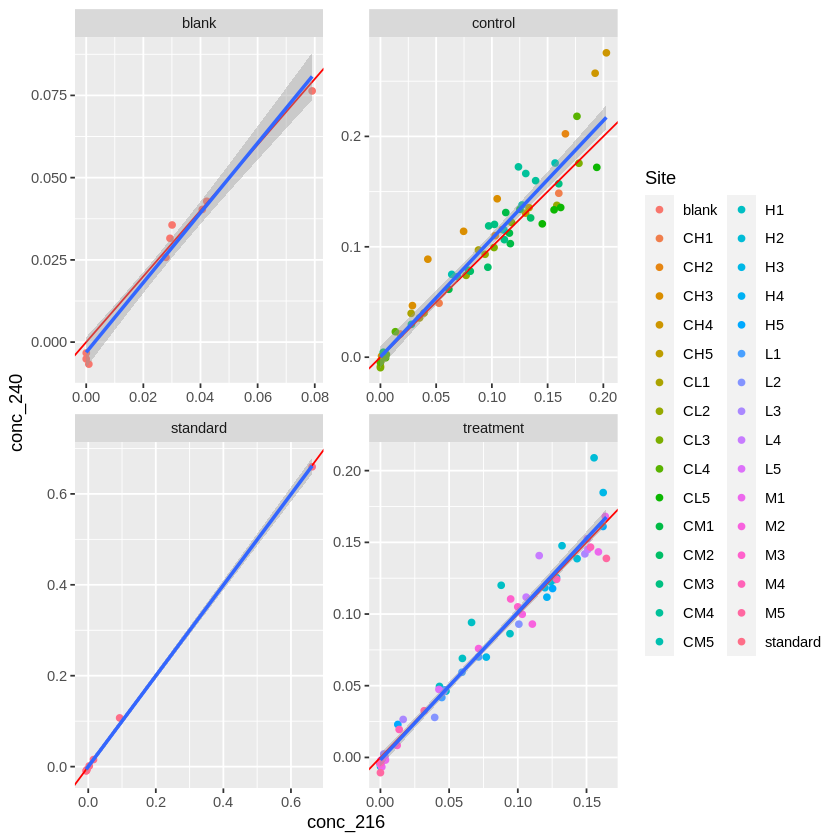

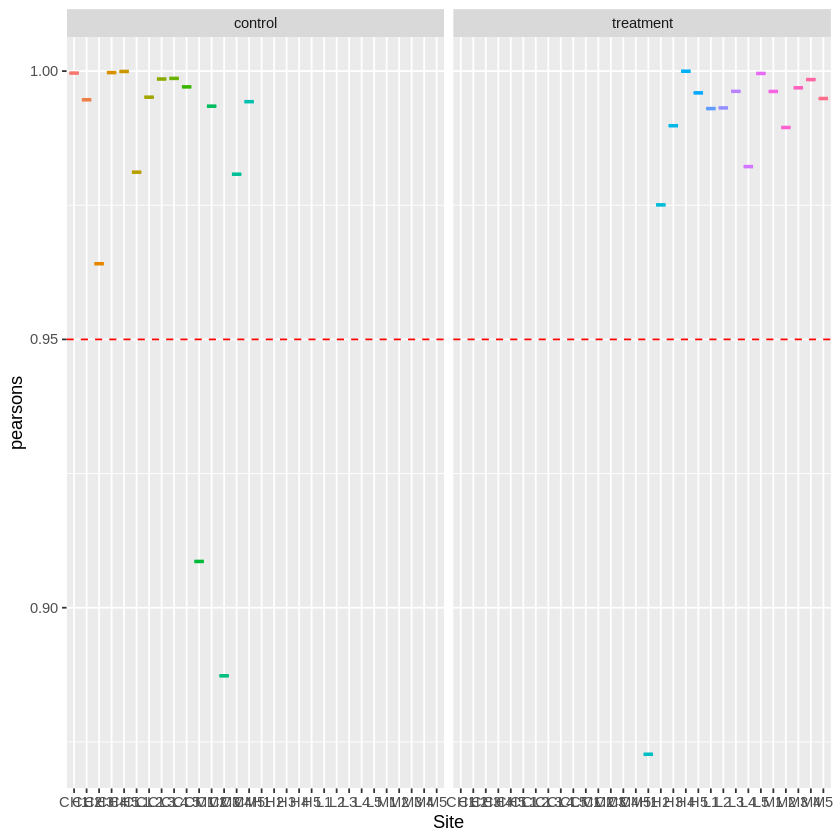

In [15]:
bpca_dt[,conc_240 := predict(conc_240_lm,data.frame(PA_240_nm=PA_240_nm))]
bpca_dt[,conc_216 := predict(conc_216_lm,data.frame(PA_216_nm= (PA_216_nm )))]
bpca_dt[Treatment=='standard',Site:='standard']
bpca_dt[Treatment=='blank',Site:='blank']
bpca_dt[Treatment!='standard',conc_216 := (conc_216^2)/10]
bpca_dt[,pearsons:=cor(conc_240[!is.na(conc_240) & !is.na(conc_216)],conc_216[!is.na(conc_240) & !is.na(conc_216)]),by = .(Site)]

# bpca_dt[pearsons < .95][,list(pearsons = pearsons[1]),by=Site]
bpca_dt[Treatment=='blank']$pearsons %>% mean
bpca_dt[ ] %>%
  ggplot(aes(x=conc_216 ,y=conc_240)) +
  geom_point(aes(color=Site))+
  geom_abline(color='red')+
  geom_smooth(method='lm')+
  # geom_point(data=bpca_dt[conc_240<1 &Site == 'CL2'],method='lm',color='orange')+

  # geom_smooth(data=bpca_dt[conc_240<1 &Site == 'CL2'],method='lm',color='orange')+
  facet_wrap(Treatment~.,scales = 'free')

bpca_dt[Treatment %in% c('control','treatment')  ]  %>%
  ggplot(aes(y=pearsons,x=Site)) +
  geom_boxplot(aes(color=Site))+
  theme(legend.position = "none")  +
  geom_hline(yintercept = .95,color='red',linetype='dashed')+
  # geom_abline(color='red')+
  # geom_smooth(method='lm')+
  facet_wrap(Treatment~.)

In [16]:
# bpca_dt %>% head

In [17]:
bpca_dt[,Depth := paste0(Depth_upper,'-',Depth_lower) %>%  factor(levels= c('0-5','5-10','10-20','10-30','20-30','blank'))]

In [18]:
bpca_dt[is.na(Depth),Depth:='blank']

In [19]:
bpca_dt[,conc_mean:= mean(c(conc_240,conc_216),na.rm=T),by=1:nrow(bpca_dt)]

In [20]:
# bpca_dt %>%head

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


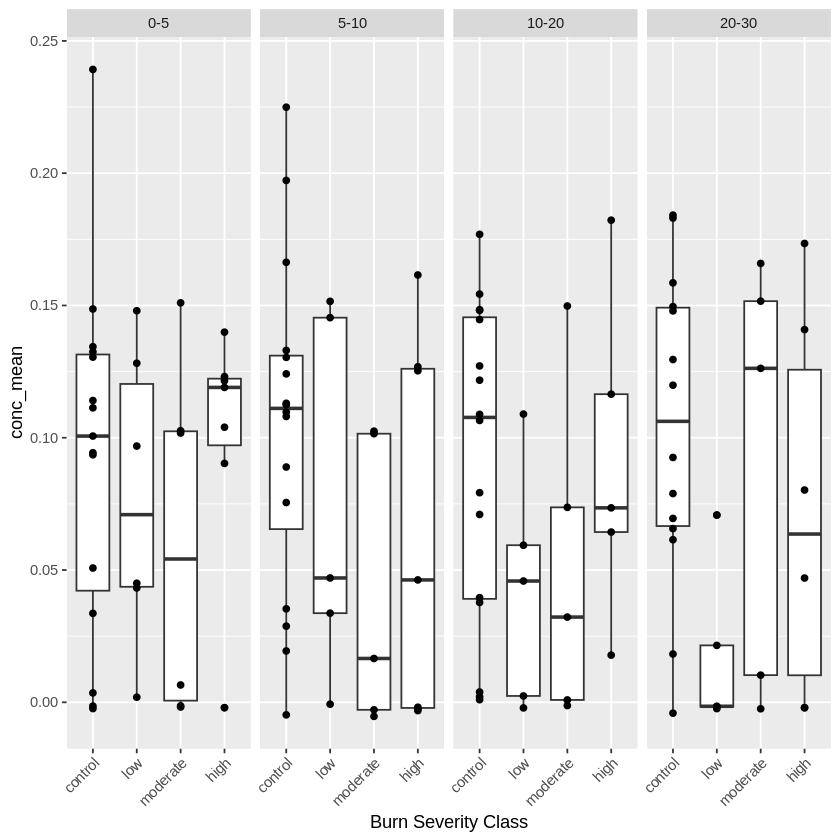

In [21]:
bpca_dt[!is.na(`Burn_severity`) &
        Burn_severity != 'blank'  &
        Depth != '10-30' ] %>%

ggplot(aes(x = factor(Burn_severity,
        level=c('control', 'low', 'moderate','high')),
        y = conc_mean)) +
    geom_boxplot( ) +
    geom_point()+
    facet_grid(.~Depth) +
    # ylim(0,1000000)+
    xlab('Burn Severity Class') +
        theme(axis.text.x = element_text(angle = 45, hjust=1))

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


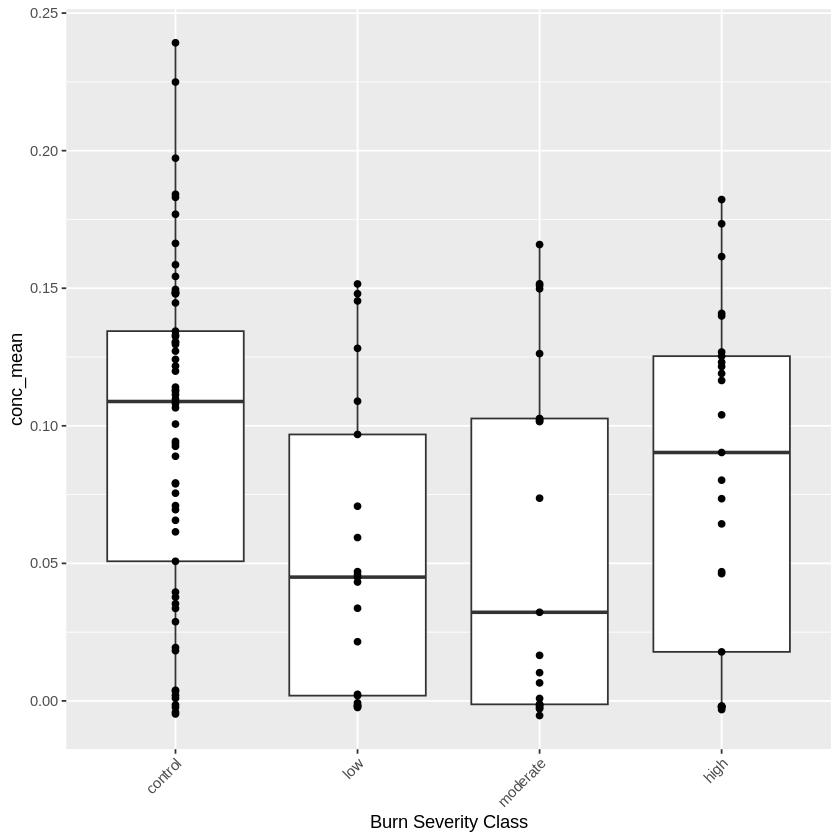

In [22]:
bpca_dt[!is.na(`Burn_severity`) &
        Burn_severity != 'blank'  &
        Depth != '10-30' ] %>%

ggplot(aes(x = factor(Burn_severity,
        level=c('control', 'low', 'moderate','high')),
        y = conc_mean)) +
    geom_boxplot( ) +
    geom_point()+
    # facet_grid(.~.) +
    # ylim(0,1000000)+
    xlab('Burn Severity Class') +
        theme(axis.text.x = element_text(angle = 45, hjust=1))

Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


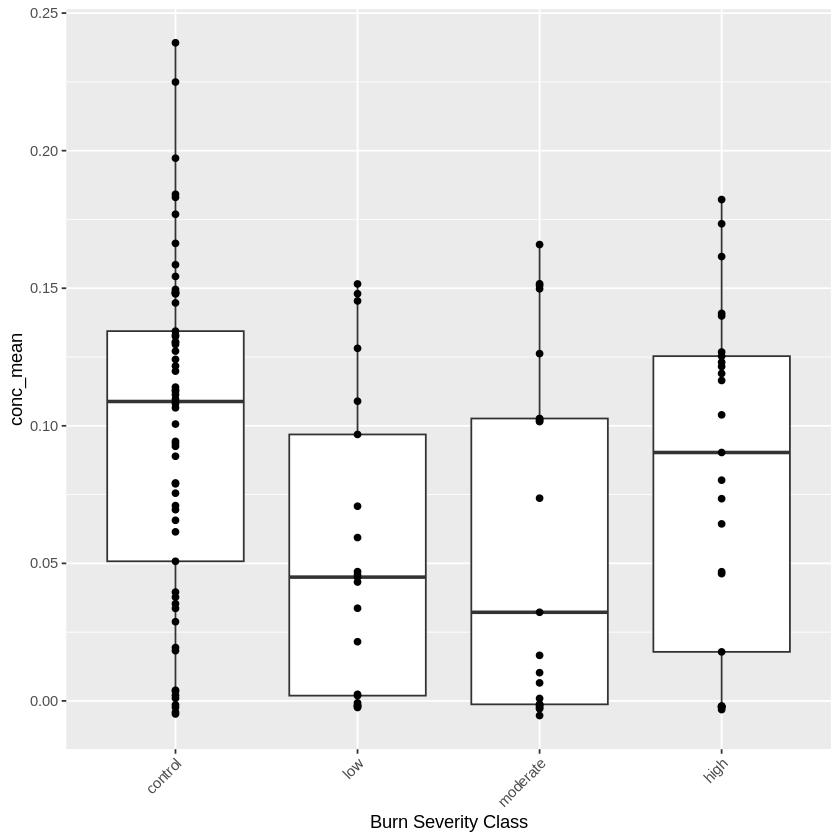

In [23]:
bpca_dt[!is.na(`Burn_severity`) &
        Burn_severity != 'blank'  &
        Depth != '10-30' ] %>%

ggplot(aes(x = factor(Burn_severity,
        level=c('control', 'low', 'moderate','high')),
        y = conc_mean)) +
    geom_boxplot( ) +
    geom_point()+
    # geom_smooth(method = 'lm')+
    # facet_grid(.~.) +
    #  ylim(0,10000000)+
#   geom_smooth(method = 'lm')+
    xlab('Burn Severity Class') +
        theme(axis.text.x = element_text(angle = 45, hjust=1))


In [24]:
# LF_stoic_dt %>% head

In [25]:
LF_stoic_dt <- data_list[["Frac BPCA"]]
LF_stoic_dt[,Depth := paste0(depth_upper_cm %>% as.numeric,'-',depth_lower_cm %>% as.numeric) %>%  factor(levels= c('0-5','5-10','10-20','10-30','20-30','blank'))]

Warning message in depth_upper_cm %>% as.numeric:
“NAs introduced by coercion”
Warning message in depth_lower_cm %>% as.numeric:
“NAs introduced by coercion”


In [26]:
LF_stoic_dt$PA_240_nm  <- LF_stoic_dt$`240_nm_PA`
LF_stoic_dt$PA_216_nm  <- LF_stoic_dt$`216_nm_PA`


LF_stoic_dt[,conc_240 := predict(conc_240_lm,data.frame(PA_240_nm=PA_240_nm))]
LF_stoic_dt[,conc_216 := predict(conc_216_lm,data.frame(PA_216_nm= (PA_216_nm )))]
LF_stoic_dt[ ,conc_216 := (conc_216^2)/10]

LF_stoic_dt[,blank_conc_240 := predict(conc_240_lm,data.frame(PA_240_nm=blank1_240_nm_PA))]
LF_stoic_dt[,blank_conc_216 := predict(conc_216_lm,data.frame(PA_216_nm= (blank1_216_nm_PA )))]
LF_stoic_dt[ ,blank_conc_216 := (blank_conc_216^2)/10]

In [27]:
# LF_stoic_dt %>%names

In [28]:
LF_stoic_dt[conc_240>.8]$conc_240 <- NA

In [29]:
LF_stoic_dt %>% names

[1] "site"                           "burn_severity"                 
 [3] "depth_upper_cm"                 "depth_lower_cm"                
 [5] "fraction"                       "fractionation_mass_recovered_g"
 [7] "starting_fract_mass_soil_g"     "mass_proportion_recovered"     
 [9] "recovery"                       "C_perc"                        
[11] "N_perc"                         "rerun"                         
[13] "frac_notes"                     "accept"                        
[15] "BPCA_Run"                       "BPCA_Run2"                     
[17] "240_nm_PA"                      "216_nm_PA"                     
[19] "BPCA_rep1_notes"                "240_nm_PA_dupe"                
[21] "216_nm_PA_dupe"                 "BPCA_rep2_notes"               
[23] "blank1_240_nm_PA"               "blank1_216_nm_PA"              
[25] "blank2_240_nm_PA"               "blank2_216_nm_PA"              
[27] "Depth"                          "PA_240_nm"                     
[29] "PA_216_nm"                      "conc_240"                      
[31] "conc_216"                       "blank_conc_240"                
[33] "blank_conc_216"

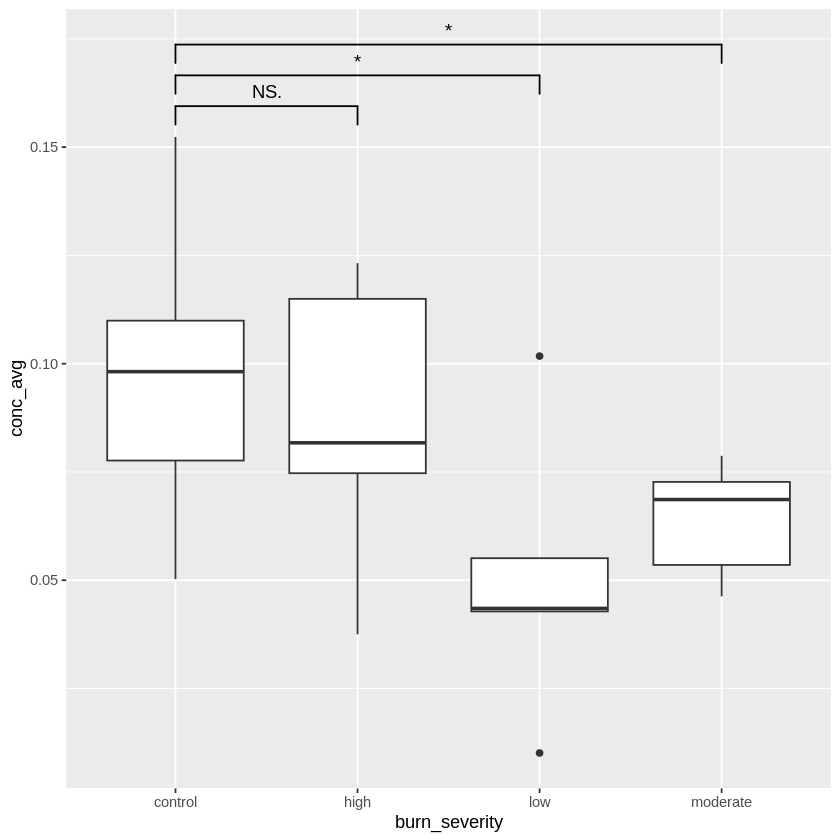

In [30]:

LF_stoic_dt[,Depth := factor(Depth, levels = c('0-5','5-10','10-20','20-30'))]
LF_stoic_dt[,conc_avg := mean(c(conc_216,conc_240),na.rm=T),by=1:nrow(LF_stoic_dt)]



LF_stoic_dt[!is.na(Depth)][,list(conc_avg = mean(conc_avg,na.rm=T)),by=.(site,burn_severity)] %>%
ggplot(aes(y=conc_avg,x=burn_severity))+
  geom_signif(aes(),comparisons = list(c(1,2),c(1,3),c(1,4)),
            map_signif_level=TRUE,step_increase=.05) +
    geom_boxplot(aes(group=burn_severity))
    # facet_wrap(.~.)


In [42]:
LF_stoic_dt_old %>% names %>% print

character(0)


In [44]:
join_dt <- LF_stoic_dt_old[,.(Site,Depth,Fract,bpca_starting_mass_mg)]

In [45]:
names(join_dt) <- c('site','Depth','fraction','bpca_starting_mass_mg')

In [46]:
LF_stoic_dt[,Burn_severity := factor(burn_severity,levels=c('control','high', 'moderate', 'low'))]


In [47]:
#  LF_stoic_dt<- hold_dt


In [48]:
LF_stoic_dt <- merge(LF_stoic_dt,join_dt,by=c('site','Depth','fraction'),all = T)

-ANOVA to test for differences in POM-PyC by burn severity
-ANOVA to test for differences in POM-C vs. MAOM-C

In [49]:

LF_stoic_dt[,burn_severity :=factor(burn_severity,
        level=c('control', 'low', 'moderate','high'))]

In [50]:
LF_stoic_dt$g_kg <- (LF_stoic_dt$conc_avg/LF_stoic_dt$bpca_starting_mass_mg)
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),list(g_kg=mean(g_kg,na.rm = T)),by=.(burn_severity,site,Depth)] %>%
aov(g_kg ~ burn_severity, data = .) %>%
summary()

               Df  Sum Sq   Mean Sq F value Pr(>F)   
burn_severity   3 0.00375 0.0012495   4.092 0.0085 **
Residuals     111 0.03389 0.0003053                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
5 observations deleted due to missingness

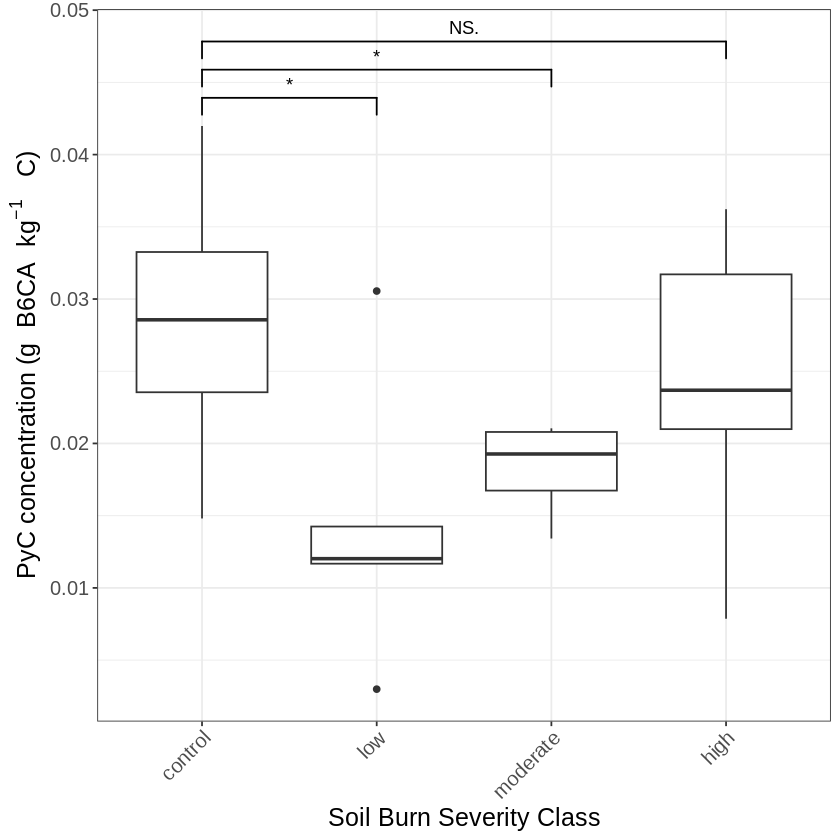

In [51]:
# (conc_240/bpca_starting_mass_mg)*(fractionation_mass_recovered_g/starting_fract_mass_soil_g)*(C/100)
LF_stoic_dt[,g_kg := (conc_avg/bpca_starting_mass_mg) ]
LF_stoic_dt[,g_kg := mass_proportion_recovered/conc_avg,by=1:nrow(LF_stoic_dt)]
LF_stoic_dt$g_kg <- (LF_stoic_dt$conc_avg/LF_stoic_dt$bpca_starting_mass_mg)
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),list(g_kg=mean(g_kg,na.rm = T)),by=.(burn_severity,site)] %>%
ggplot(aes(x = burn_severity, y = g_kg)) +
  geom_boxplot() +
  # geom_point(aes(y=group_mean),color='red')+
  #(bquote('Mean light fraction soil carbon content ('*mg~ 'C' ~g^-1~'soil'*')'))
  ylab(bquote('PyC concentration ('*g~ 'B6CA'~kg^-1~' C'*')'))+
  xlab('Soil Burn Severity Class') +
      theme_bw()+
      theme(text = element_text(size=15),axis.text.x = element_text(angle = 45, hjust=1)) +
  geom_signif(aes(),comparisons = list(c(1,2),c(1,3),c(1,4)),
            map_signif_level=TRUE,step_increase=.05) +
  # facet_grid(.~Depth) +
  coord_cartesian(expand=TRUE)

In [52]:
# LF_stoic_dt[,g_kg := (conc_avg/bpca_starting_mass_mg) ]
# LF_stoic_dt[,g_kg := mass_proportion_recovered/conc_avg,by=1:nrow(LF_stoic_dt)]
LF_stoic_dt$g_kg <- (LF_stoic_dt$conc_avg/LF_stoic_dt$bpca_starting_mass_mg)
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),]  %>%
aov(g_kg ~ burn_severity +Depth, data = .) %>%
summary()

               Df  Sum Sq   Mean Sq F value Pr(>F)  
burn_severity   3 0.00323 0.0010769   3.495 0.0177 *
Depth           3 0.00044 0.0001456   0.473 0.7019  
Residuals     122 0.03759 0.0003081                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
302 observations deleted due to missingness

Interpretation:

    Burn Severity:
        The p-value for burn_severity is 0.0264, which is less than 0.05. This indicates that there are statistically significant differences in your dependent variable across the different levels of burn_severity.
        The asterisk (*) next to the p-value for burn_severity denotes significance at the 0.05 level.

    Depth:
        The p-value for Depth is 0.5849, which is greater than 0.05. This suggests that the differences in your dependent variable across the different levels of Depth are not statistically significant.

    Residuals:
        This represents the variability not explained by the two factors.

    Note on Missingness:
        The output mentions "48 observations deleted due to missingness." This indicates that some data points were not included in the analysis due to missing values. It's important to consider whether this missingness might bias your results.

Those two anova together show that there are statistically signficant differences in PyC, and that they vary by burn severity, not depth.

Warning message:
“Removed 302 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 302 rows containing non-finite values (`stat_signif()`).”


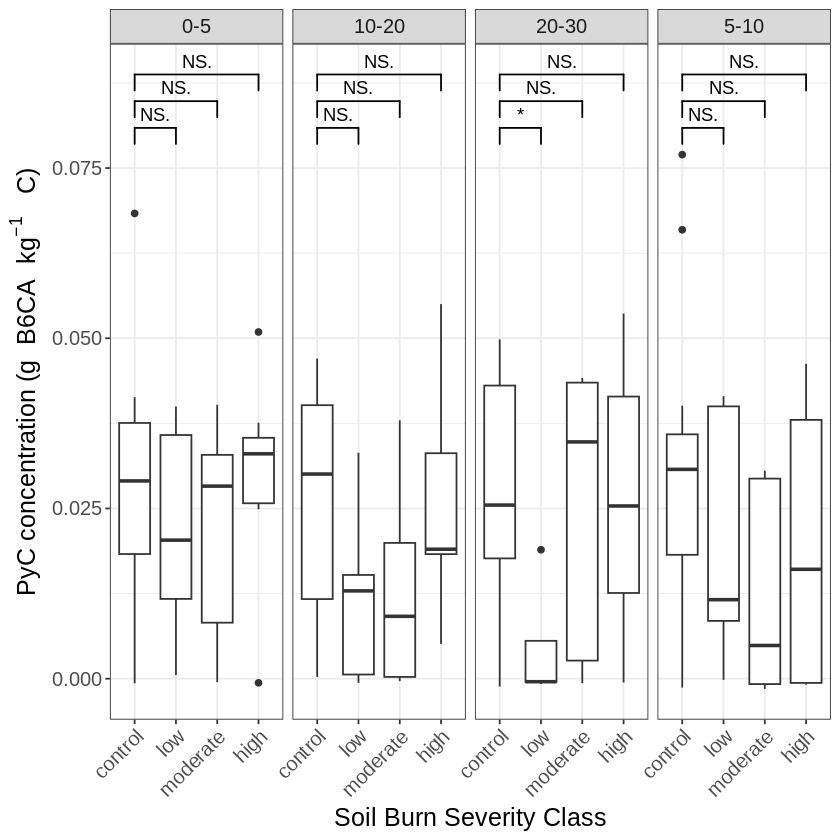

In [53]:

LF_stoic_dt$g_kg <- (LF_stoic_dt$conc_avg/LF_stoic_dt$bpca_starting_mass_mg)
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),] %>%
ggplot(aes(x = burn_severity, y = g_kg)) +
  geom_boxplot() +
  # geom_point(aes(y=group_mean),color='red')+
  #(bquote('Mean light fraction soil carbon content ('*mg~ 'C' ~g^-1~'soil'*')'))
  ylab(bquote('PyC concentration ('*g~ 'B6CA'~kg^-1~' C'*')'))+
  xlab('Soil Burn Severity Class') +
      theme_bw()+
      theme(text = element_text(size=15),axis.text.x = element_text(angle = 45, hjust=1)) +
  geom_signif(aes(),comparisons = list(c(1,2),c(1,3),c(1,4)),
            map_signif_level=TRUE,step_increase=.05) +
  facet_grid(.~Depth) +
  coord_cartesian(expand=TRUE)

In [54]:
# LF_stoic_dt[,g_kg := (conc_avg/bpca_starting_mass_mg) ]
# LF_stoic_dt[,g_kg := mass_proportion_recovered/conc_avg,by=1:nrow(LF_stoic_dt)]
# LF_stoic_dt$g_kg <- (LF_stoic_dt$conc_avg/LF_stoic_dt$bpca_starting_mass_mg)
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),][fraction == 'LF']  %>%
aov(C_perc ~ burn_severity + Depth, data = .) %>%
summary()

LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),][fraction == 'HF']  %>%
aov(C_perc ~ burn_severity + Depth, data = .) %>%
summary()

LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),][fraction!='BULK']   %>%
aov(C_perc ~ burn_severity + Depth +fraction, data = .) %>%
summary()

               Df Sum Sq Mean Sq F value   Pr(>F)    
burn_severity   3    469  156.48   7.799 6.57e-05 ***
Depth           3    284   94.80   4.725  0.00342 ** 
Residuals     170   3411   20.06                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

               Df Sum Sq Mean Sq F value   Pr(>F)    
burn_severity   3   1.60   0.533   0.905 0.440935    
Depth           3  12.61   4.204   7.139 0.000181 ***
Residuals     127  74.80   0.589                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

               Df Sum Sq Mean Sq  F value   Pr(>F)    
burn_severity   3    361     120    9.547 4.83e-06 ***
Depth           3    401     134   10.594 1.21e-06 ***
fraction        1  42631   42631 3379.556  < 2e-16 ***
Residuals     303   3822      13                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

There is also a signficant difference in the overall percentatge of carbon by burn_severity, depth. This is only true for the light fraction. In other words, burn severity also impacts the percent carbon  (in the light fraction only).

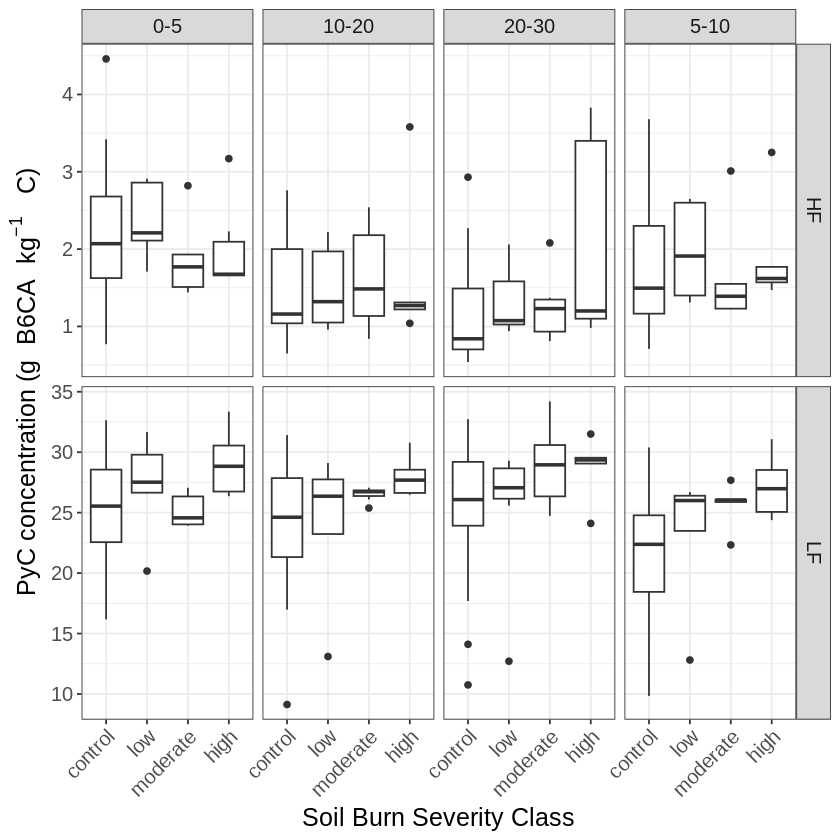

In [55]:

LF_stoic_dt$g_kg <- (LF_stoic_dt$conc_avg/LF_stoic_dt$bpca_starting_mass_mg)
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity)&fraction!='BULK',] %>%
ggplot(aes(x = burn_severity, y = C_perc)) +
  geom_boxplot() +
  # geom_point(aes(y=group_mean),color='red')+
  #(bquote('Mean light fraction soil carbon content ('*mg~ 'C' ~g^-1~'soil'*')'))
  ylab(bquote('PyC concentration ('*g~ 'B6CA'~kg^-1~' C'*')'))+
  xlab('Soil Burn Severity Class') +
      theme_bw()+
      theme(text = element_text(size=15),axis.text.x = element_text(angle = 45, hjust=1)) +
  # geom_signif(aes(),comparisons = list(c(1,2),c(1,3),c(1,4)),
  #           map_signif_level=TRUE,step_increase=.05) +
  facet_grid(fraction~Depth,scales='free') +
  coord_cartesian(expand=TRUE)

In [57]:
LF_stoic_dt[,Depth :=factor(Depth,
        level= c('0-5','5-10','10-20' ,'20-30' ))]

        # factor(levels= c('0-5','5-10','10-20','10-30','20-30','blank'))

In [58]:
LF_stoic_dt[,C_N:=C_perc/ N_perc]

LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),][C_perc/N_perc <100][fraction == 'LF']  %>%
aov(C_N ~ burn_severity + Depth, data = .) %>%
summary()

               Df Sum Sq Mean Sq F value   Pr(>F)    
burn_severity   3    565   188.3   3.352   0.0204 *  
Depth           3   4537  1512.5  26.933 2.83e-14 ***
Residuals     168   9434    56.2                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

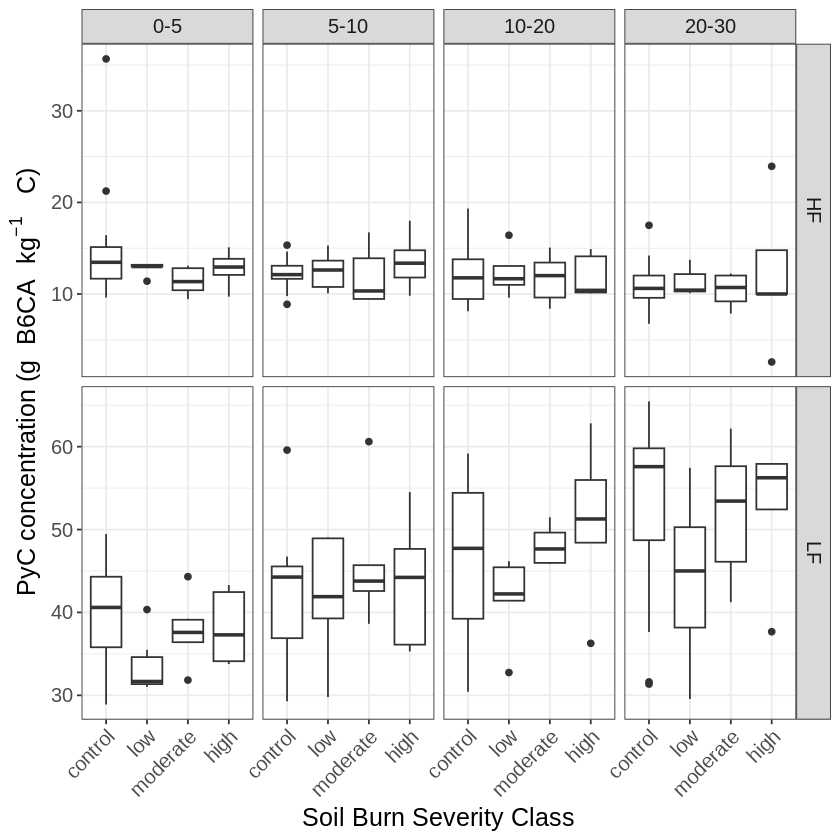

In [59]:
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),][fraction !='BULK'][C_perc/N_perc <100] %>%
ggplot(aes(x = burn_severity, y =C_N)) +
  geom_boxplot() +
  # geom_point(aes(y=group_mean),color='red')+
  #(bquote('Mean light fraction soil carbon content ('*mg~ 'C' ~g^-1~'soil'*')'))
  ylab(bquote('PyC concentration ('*g~ 'B6CA'~kg^-1~' C'*')'))+
  xlab('Soil Burn Severity Class') +
      theme_bw()+
      theme(text = element_text(size=15),axis.text.x = element_text(angle = 45, hjust=1)) +
  # geom_signif(aes(),comparisons = list(c(1,2),c(1,3),c(1,4)),
  #           map_signif_level=TRUE,step_increase=.05) +
  facet_grid(fraction~Depth,scales = 'free_y') +
  coord_cartesian(expand=TRUE)

In [60]:
LF_stoic_dt[,C_N:=C_perc/ N_perc]

LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),][C_perc/N_perc <100][fraction == 'LF']  %>%
aov(C_N ~ burn_severity + Depth, data = .) %>%
summary()

               Df Sum Sq Mean Sq F value   Pr(>F)    
burn_severity   3    565   188.3   3.352   0.0204 *  
Depth           3   4537  1512.5  26.933 2.83e-14 ***
Residuals     168   9434    56.2                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

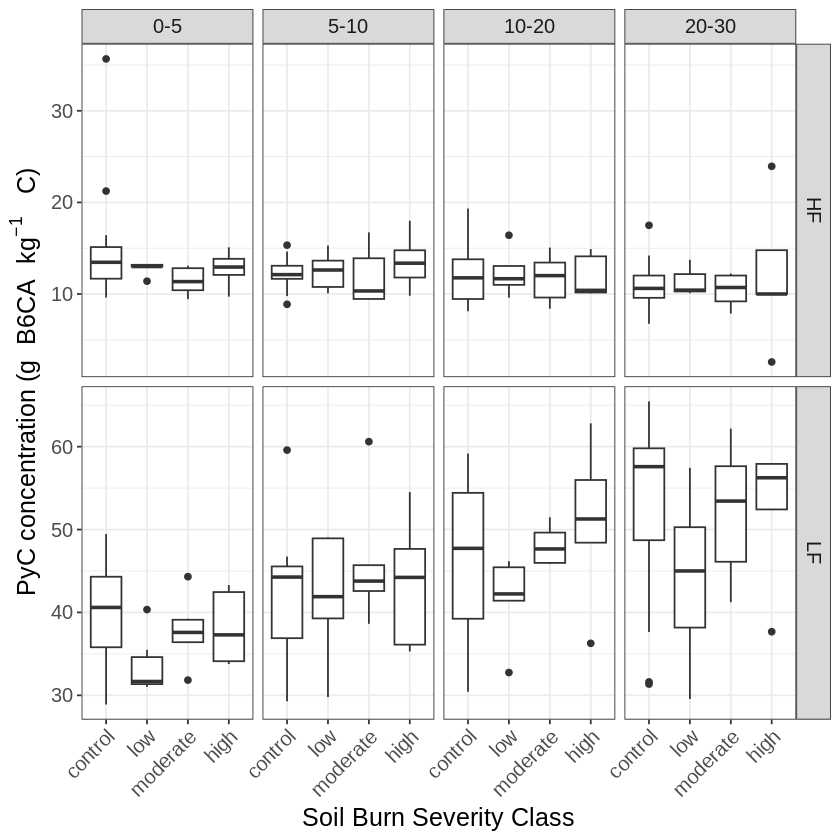

In [61]:
LF_stoic_dt[!is.na(Depth)&!is.na(burn_severity),][fraction !='BULK'][C_perc/N_perc <100] %>%
ggplot(aes(x = burn_severity, y =C_N,group=burn_severity)) +
  geom_boxplot() +
  # geom_point(aes(y=group_mean),color='red')+
  #(bquote('Mean light fraction soil carbon content ('*mg~ 'C' ~g^-1~'soil'*')'))
  ylab(bquote('PyC concentration ('*g~ 'B6CA'~kg^-1~' C'*')'))+
  xlab('Soil Burn Severity Class') +
      theme_bw()+
      theme(text = element_text(size=15),axis.text.x = element_text(angle = 45, hjust=1)) +
  # geom_signif(aes(),comparisons = list(c(1,2),c(1,3),c(1,4)),
  #           map_signif_level=TRUE,step_increase=.05) +
  facet_grid(fraction~Depth,scales = 'free_y') +
  coord_cartesian(expand=TRUE)

In [62]:
LF_stoic_dt[,exp_group:=site %>% gsub('C','',.) %>% gsub("[0-9]", "", .)]


In [63]:
LF_stoic_dt[,lf_per_carb := C_perc*mass_proportion_recovered*g_kg]

In [75]:
names(LF_stoic_dt)

[1] "site"                           "Depth"                         
 [3] "fraction"                       "burn_severity"                 
 [5] "depth_upper_cm"                 "depth_lower_cm"                
 [7] "fractionation_mass_recovered_g" "starting_fract_mass_soil_g"    
 [9] "mass_proportion_recovered"      "recovery"                      
[11] "C_perc"                         "N_perc"                        
[13] "rerun"                          "frac_notes"                    
[15] "accept"                         "BPCA_Run"                      
[17] "BPCA_Run2"                      "240_nm_PA"                     
[19] "216_nm_PA"                      "BPCA_rep1_notes"               
[21] "240_nm_PA_dupe"                 "216_nm_PA_dupe"                
[23] "BPCA_rep2_notes"                "blank1_240_nm_PA"              
[25] "blank1_216_nm_PA"               "blank2_240_nm_PA"              
[27] "blank2_216_nm_PA"               "PA_240_nm"                     
[29] "PA_216_nm"                      "conc_240"                      
[31] "conc_216"                       "blank_conc_240"                
[33] "blank_conc_216"                 "conc_avg"                      
[35] "Burn_severity"                  "bpca_starting_mass_mg"         
[37] "g_kg"                           "C_N"                           
[39] "exp_group"                      "lf_per_carb"

In [ ]:
names()

In [90]:
names(data_list[['Soil Samples']]) <- c('site','Depth Increment',"depth_upper_cm","depth_lower_cm","Dry mass soil composite","Rock mass","Rock volume","Db","Notes")
LF_stoic_dt <- merge(LF_stoic_dt,data_list[['Soil Samples']][,c('site',"depth_upper_cm","depth_lower_cm","Db")],by = c('site','depth_upper_cm','depth_lower_cm'))

In [114]:
names(LF_stoic_dt)

[1] "site"                           "depth_upper_cm"                
 [3] "depth_lower_cm"                 "Depth"                         
 [5] "fraction"                       "burn_severity"                 
 [7] "fractionation_mass_recovered_g" "starting_fract_mass_soil_g"    
 [9] "mass_proportion_recovered"      "recovery"                      
[11] "C_perc"                         "N_perc"                        
[13] "rerun"                          "frac_notes"                    
[15] "accept"                         "BPCA_Run"                      
[17] "BPCA_Run2"                      "240_nm_PA"                     
[19] "216_nm_PA"                      "BPCA_rep1_notes"               
[21] "240_nm_PA_dupe"                 "216_nm_PA_dupe"                
[23] "BPCA_rep2_notes"                "blank1_240_nm_PA"              
[25] "blank1_216_nm_PA"               "blank2_240_nm_PA"              
[27] "blank2_216_nm_PA"               "PA_240_nm"                     
[29] "PA_216_nm"                      "conc_240"                      
[31] "conc_216"                       "blank_conc_240"                
[33] "blank_conc_216"                 "conc_avg"                      
[35] "Burn_severity"                  "bpca_starting_mass_mg"         
[37] "g_kg"                           "C_N"                           
[39] "exp_group"                      "lf_per_carb"                   
[41] "Db"

In [128]:
LF_stoic_dt[,carbon_stock:= (depth_lower_cm %>% as.numeric - depth_upper_cm%>% as.numeric )*((Db%>% as.numeric ))*(C_perc/100)*100]

In [145]:
cwd_rate_table %>% names

[1] "Site"                   "decayed_mass_kg"        "total_input"           
[4] "burn_decayed_mass_kg"   "wood_input_rate"        "wood_departure_rate"   
[7] "wood_accumulation_rate" "years_to_capacity"      "years_to_recovery"

In [147]:
names(cwd_rate_table)[1] <- 'site'

In [149]:
LF_stoic_dt <- LF_stoic_dt %>% merge(cwd_rate_table,by='site')

In [150]:
cwd_rate_table %>% names

[1] "site"                   "decayed_mass_kg"        "total_input"           
[4] "burn_decayed_mass_kg"   "wood_input_rate"        "wood_departure_rate"   
[7] "wood_accumulation_rate" "years_to_capacity"      "years_to_recovery"

In [192]:
# LF_stoic_dt[fraction == 'LF'][exp_group =='H'][burn_severity=='control'][accept=='T']

In [208]:
t_tests_dt <-
c('HF','LF','BULK') %>%
lapply(function(frac){
# c('g_kg','C_N','C_perc','N_perc','mass_proportion_recovered','lf_per_carb') %>%
c('C_N','C_perc','N_perc','carbon_stock','burn_decayed_mass_kg' ) %>%
lapply(function(variable){
c('H','M','L') %>%
lapply(function(group){
control_dt <- LF_stoic_dt[fraction == frac][exp_group ==group][burn_severity=='control'][accept=='T']
exp_dt <- LF_stoic_dt[fraction == frac][exp_group ==group][burn_severity!='control'][accept=='T']

exp_dt$Depth %>% levels %>%
lapply(function(y){

t_result <- t.test(control_dt[fraction == frac][Depth==y][[variable]] ,exp_dt[fraction == frac][Depth==y][[variable]] )
data.table(fraction=frac,
          variable=variable,
          burn_severity = unique(exp_dt$burn_severity),
          Depth=y,p=t_result$p.value,
          control_m = mean(control_dt[fraction == frac][Depth==y][[variable]]%>%unique,na.rm=T),
          control_sd = sd(control_dt[fraction == frac][Depth==y][[variable]]%>%unique,na.rm=T),
          control_n = length(control_dt[fraction == frac][Depth==y][[variable]]%>%unique ),
          exp_m = mean(exp_dt[fraction == frac][Depth==y][[variable]]%>%unique,na.rm=T),
          exp_sd = sd(exp_dt[fraction == frac][Depth==y][[variable]]%>%unique,na.rm=T),
          exp_n = length(exp_dt[fraction == frac][Depth==y][[variable]] %>%unique)
          )

}) %>% rbindlist
}) %>% rbindlist
}) %>% rbindlist
}) %>% rbindlist

In [209]:
t_tests_dt[variable=='burn_decayed_mass_kg'][Depth=='0-5'&fraction=='BULK']

fraction,variable,burn_severity,Depth,p,control_m,control_sd,control_n,exp_m,exp_sd,exp_n
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
BULK,burn_decayed_mass_kg,high,0-5,0.14850514,6.764894,7.718483,5,0.5957299,0.5988446,5
BULK,burn_decayed_mass_kg,moderate,0-5,0.17175069,7.858705,7.483177,5,2.1485254,3.0556919,5
BULK,burn_decayed_mass_kg,low,0-5,0.03505987,7.990749,5.117360,5,0.9037810,0.9423704,5


In [210]:
# c('g_kg','C_N','C_perc','N_perc','mass_proportion_recovered','lf_per_carb')
t_tests_dt[,exp_m_norm := exp_m/control_m]
# t_tests_dt[variable=='g_kg'] %>%
# aov(exp_m_norm ~ burn_severity+Depth, data = .) %>%
# summary()

t_tests_dt[variable=='C_N'] %>%
aov(exp_m_norm ~ burn_severity+Depth+fraction, data = .) %>%
summary()

t_tests_dt[variable=='C_perc'] %>%
aov(exp_m_norm ~ burn_severity+Depth+fraction, data = .) %>%
summary()

t_tests_dt[variable=='N_perc'] %>%
aov(exp_m_norm ~ burn_severity+Depth+fraction, data = .) %>%
summary()

t_tests_dt[variable=='burn_decayed_mass_kg'] %>%
aov(exp_m_norm ~ burn_severity+Depth+fraction, data = .) %>%
summary()

# t_tests_dt[variable=='lf_per_carb'] %>%
# aov(exp_m_norm ~ burn_severity+Depth+fraction, data = .) %>%
# summary()

# t_tests_dt[variable=='mass_proportion_recovered'] %>%
# aov(exp_m_norm ~ burn_severity+Depth, data = .) %>%
# summary()

              Df Sum Sq Mean Sq F value Pr(>F)  
burn_severity  2 0.4186 0.20930   3.419 0.0469 *
Depth          3 0.2953 0.09844   1.608 0.2098  
fraction       2 0.1091 0.05457   0.891 0.4214  
Residuals     28 1.7142 0.06122                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

              Df Sum Sq Mean Sq F value Pr(>F)
burn_severity  2 0.0481 0.02403   0.691  0.509
Depth          3 0.1531 0.05104   1.468  0.245
fraction       2 0.0342 0.01711   0.492  0.617
Residuals     28 0.9737 0.03478               

              Df Sum Sq Mean Sq F value Pr(>F)
burn_severity  2 0.0802 0.04012   1.496  0.241
Depth          3 0.1056 0.03521   1.313  0.290
fraction       2 0.0039 0.00193   0.072  0.931
Residuals     28 0.7511 0.02682               

              Df Sum Sq Mean Sq   F value Pr(>F)    
burn_severity  2 0.2427  0.1213 2.694e+31 <2e-16 ***
Depth          3 0.0000  0.0000 1.159e+00  0.343    
fraction       2 0.0000  0.0000 7.100e-02  0.931    
Residuals     28 0.0000  0.0000                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [211]:
t_tests_dt[,exp_m_norm_sd := sd(exp_m/control_m),by=.(burn_severity,variable)]
t_tests_dt[,exp_m_norm_m := mean(exp_m_norm),by=.(burn_severity)]

In [212]:
LF_stoic_dt[burn_severity=='control' & exp_group =='M' &fraction =='LF' &Depth == '5-10']$C_per
# LF_stoic_dt[burn_severity=='control' & exp_group =='M' &fraction =='LF' &Depth == '5-10'] %>% print

[1] 24.28  9.84  9.84 17.40 17.40 24.80 23.37 24.79 24.79

In [213]:
t_tests_dt[,exp_m_norm:=exp_m/control_m]

In [214]:
t_tests_dt[variable=='C_perc' &burn_severity=='high']

# t_tests_dt[variable=='g_kg']

fraction,variable,burn_severity,Depth,p,control_m,control_sd,control_n,exp_m,exp_sd,exp_n,exp_m_norm,exp_m_norm_sd,exp_m_norm_m
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
HF,C_perc,high,0-5,0.43784042,2.512,1.3058024,5,2.0425,0.7518588,4,0.8130971,0.2921449,0.8410905
HF,C_perc,high,5-10,0.90594653,1.994,0.7613672,5,1.9360,0.7424823,5,0.9709127,0.2921449,0.8410905
HF,C_perc,high,10-20,0.83634616,1.558,0.7733822,5,1.6840,1.0649084,5,1.0808729,0.2921449,0.8410905
HF,C_perc,high,20-30,0.24795046,1.230,0.5640479,5,2.1020,1.3916968,5,1.7089431,0.2921449,0.8410905
LF,C_perc,high,0-5,0.07200774,25.020,5.8714095,5,29.4240,2.9686074,5,1.1760192,0.2921449,0.8410905
LF,C_perc,high,5-10,0.03651932,21.360,4.4336610,5,27.0360,2.6329983,5,1.2657303,0.2921449,0.8410905
LF,C_perc,high,10-20,0.12027888,20.686,8.3293865,5,28.0260,1.7543460,5,1.3548294,0.2921449,0.8410905
LF,C_perc,high,20-30,0.16191377,21.674,9.3768401,5,28.7140,2.7467217,5,1.3248131,0.2921449,0.8410905
BULK,C_perc,high,0-5,0.26402635,8.510,4.4662960,5,5.8820,1.1451288,5,0.6911868,0.2921449,0.8410905


In [220]:
t_tests_dt[variable %in% c( 'burn_decayed_mass_kg') &Depth  %in% '0-5'&fraction=='BULK']

fraction,variable,burn_severity,Depth,p,control_m,control_sd,control_n,exp_m,exp_sd,exp_n,exp_m_norm,exp_m_norm_sd,exp_m_norm_m
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
BULK,burn_decayed_mass_kg,high,0-5,0.14850514,6.764894,7.718483,5,0.5957299,0.5988446,5,0.08806198,0,0.8410905
BULK,burn_decayed_mass_kg,moderate,0-5,0.17175069,7.858705,7.483177,5,2.1485254,3.0556919,5,0.27339433,0,0.8680297
BULK,burn_decayed_mass_kg,low,0-5,0.03505987,7.990749,5.117360,5,0.9037810,0.9423704,5,0.11310342,0,0.8838088


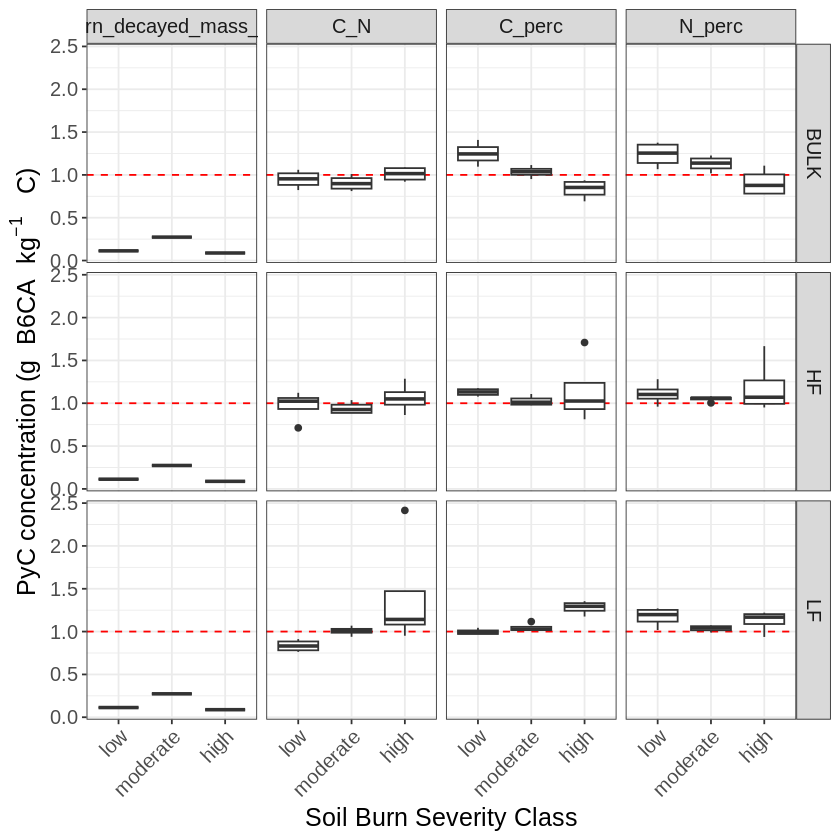

In [216]:
t_tests_dt[variable %in% c( 'C_N','C_perc','N_perc','burn_decayed_mass_kg')] %>%
ggplot(aes(x = burn_severity, y =exp_m_norm,group=burn_severity)) +
  geom_hline(yintercept = 1,color='red',linetype = 'dashed')+
  geom_boxplot() +
  # geom_point(aes(y=exp_m_norm),color='red')+
  # geom_errorbar(aes(ymin = exp_m_norm-(exp_m_norm_sd/sqrt(4), ymax = (exp_m_norm+exp_m_norm_sd)/sqrt(4)), width = 0.2)+
  #(bquote('Mean light fraction soil carbon content ('*mg~ 'C' ~g^-1~'soil'*')'))
  ylab(bquote('PyC concentration ('*g~ 'B6CA'~kg^-1~' C'*')'))+
  xlab('Soil Burn Severity Class') +
      theme_bw()+
      theme(text = element_text(size=15),axis.text.x = element_text(angle = 45, hjust=1)) +
  # ylim(0,5)+
  # geom_signif(aes(),comparisons = list(c(1,2),c(1,3),c(2,3)),
  #           map_signif_level=TRUE,step_increase=.05) +
  facet_grid(fraction~variable) +
  coord_cartesian(expand=TRUE)